<a href="https://colab.research.google.com/github/rooshanriaz/CS-351L-AI-Lab-GitHub-Repository_2022506/blob/main/Rooshan_Riaz_CS_351L_Lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shortest Path from Router 3 to Router 19:
3 -> 12 -> 0 -> 13 -> 19


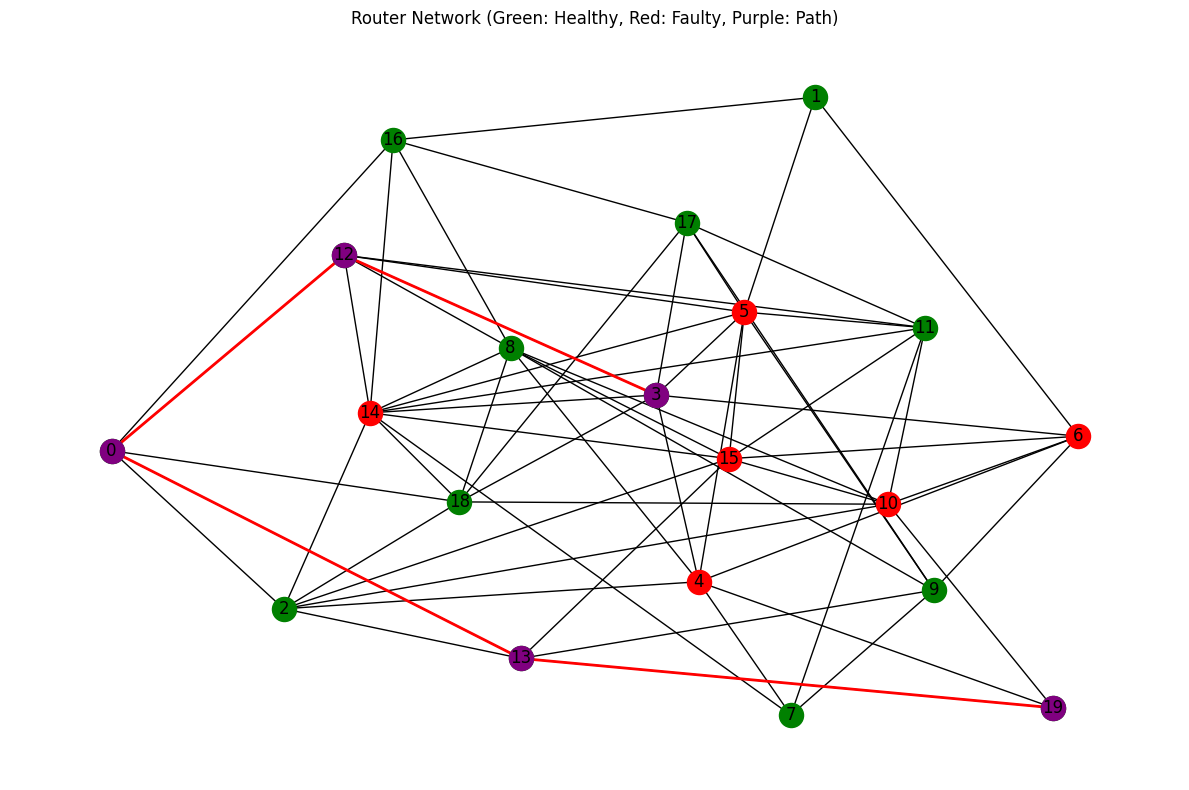

Epoch 0, Loss: 2.7111737728118896, Accuracy: 5.000000074505806%
Epoch 100, Loss: 1.8009450286626816e-05, Accuracy: 69.9999988079071%
Epoch 200, Loss: 0.0006698170327581465, Accuracy: 69.9999988079071%
Epoch 300, Loss: 6.5026104500987e-09, Accuracy: 69.9999988079071%
Epoch 400, Loss: 0.0001205813605338335, Accuracy: 69.9999988079071%
Epoch 500, Loss: 7.240074069159164e-07, Accuracy: 69.9999988079071%
Epoch 600, Loss: 9.864060956932263e-12, Accuracy: 69.9999988079071%
Epoch 700, Loss: 1.5066040429112526e-11, Accuracy: 75.0%
Epoch 800, Loss: 1.2705405424640048e-05, Accuracy: 69.9999988079071%
Epoch 900, Loss: 2.4526475295161276e-10, Accuracy: 69.9999988079071%


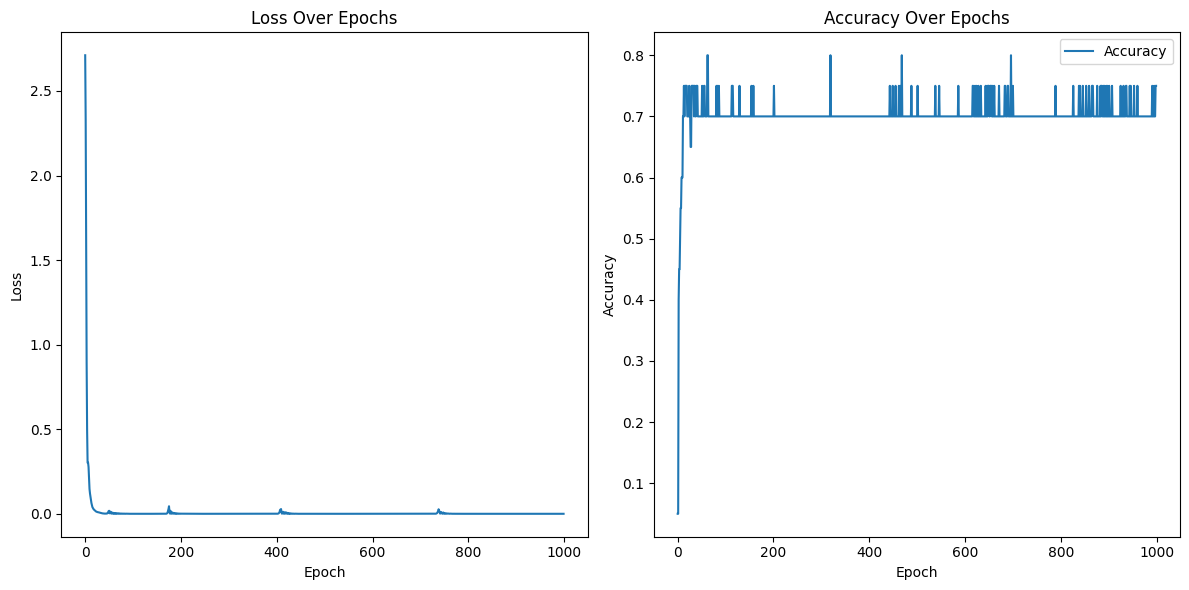

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class RouterNetwork:
    def __init__(self, num_routers=20, fault_probability=0.2):
        """
        Initialize a network of routers with potential faults

        Args:
            num_routers (int): Total number of routers in the network
            fault_probability (float): Probability of a router being faulty
        """
        self.num_routers = num_routers
        self.fault_probability = fault_probability
        self.create_network()

    def create_network(self):
        """
        Create a random network graph with potential faulty routers
        """
        # Create a random graph
        self.graph = nx.erdos_renyi_graph(self.num_routers, 0.3)

        # Randomly mark some routers as faulty
        self.faulty_routers = set(
            router for router in self.graph.nodes
            if np.random.random() < self.fault_probability
        )

        # Assign random weights to edges
        for (u, v) in self.graph.edges():
            self.graph[u][v]['weight'] = np.random.uniform(0.1, 10.0)

    def find_shortest_path(self, source, destination):
        """
        Find the shortest path avoiding faulty routers

        Args:
            source (int): Source router
            destination (int): Destination router

        Returns:
            list: Shortest path avoiding faulty routers
        """
        # Create a copy of the graph without faulty routers
        G = self.graph.copy()

        # Remove faulty routers
        G.remove_nodes_from(self.faulty_routers)

        try:
            # Find shortest path using Dijkstra's algorithm
            shortest_path = nx.shortest_path(G, source=source, target=destination, weight='weight')
            return shortest_path
        except nx.NetworkXNoPath:
            return None

    def visualize_network(self, shortest_path=None):
        """
        Visualize the network with faulty and healthy routers

        Args:
            shortest_path (list, optional): Path to highlight
        """
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)

        # Draw healthy routers in green
        healthy_routers = set(self.graph.nodes) - self.faulty_routers
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=list(healthy_routers),
            node_color='green',
            node_size=300
        )

        # Draw faulty routers in red
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=list(self.faulty_routers),
            node_color='red',
            node_size=300
        )

        # Draw edges
        nx.draw_networkx_edges(self.graph, pos)

        # Highlight shortest path if provided
        if shortest_path:
            path_edges = list(zip(shortest_path, shortest_path[1:]))
            nx.draw_networkx_edges(
                self.graph,
                pos,
                edgelist=path_edges,
                edge_color='r',
                width=2
            )
            nx.draw_networkx_nodes(
                self.graph,
                pos,
                nodelist=shortest_path,
                node_color='purple',
                node_size=300
            )

        # Draw node labels
        nx.draw_networkx_labels(self.graph, pos)

        plt.title("Router Network (Green: Healthy, Red: Faulty, Purple: Path)")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

class NeuralPathFinder(nn.Module):
    def __init__(self, num_routers):
        """
        Neural network for finding optimal paths

        Args:
            num_routers (int): Total number of routers in the network
        """
        super(NeuralPathFinder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(num_routers * num_routers, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_routers * num_routers)
        )

    def forward(self, adjacency_matrix):
        """
        Forward pass to predict optimal path

        Args:
            adjacency_matrix (torch.Tensor): Network adjacency matrix

        Returns:
            torch.Tensor: Predicted optimal path matrix
        """
        flattened = adjacency_matrix.view(-1)
        return self.network(flattened).view(adjacency_matrix.shape)

def train_path_finder(router_network, epochs=1000):
    """
    Train neural network to find optimal paths around faulty routers

    Args:
        router_network (RouterNetwork): Network configuration
        epochs (int): Number of training epochs

    Returns:
        NeuralPathFinder: Trained neural network
    """
    # Convert graph to adjacency matrix
    adj_matrix = nx.to_numpy_array(router_network.graph)

    # Mark faulty routers in adjacency matrix
    for router in router_network.faulty_routers:
        adj_matrix[router, :] = 0
        adj_matrix[:, router] = 0

    # Convert to PyTorch tensors
    adj_tensor = torch.FloatTensor(adj_matrix)

    # Initialize neural network and optimizer
    model = NeuralPathFinder(router_network.num_routers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        predicted_paths = model(adj_tensor)

        # Loss calculation
        loss = criterion(predicted_paths, adj_tensor)

        # Accuracy calculation: We calculate accuracy based on how many predictions match the adjacency matrix
        correct_predictions = (predicted_paths.argmax(dim=-1) == adj_tensor.argmax(dim=-1)).float()
        accuracy = correct_predictions.mean().item()

        loss.backward()
        optimizer.step()

        # Store loss and accuracy
        loss_history.append(loss.item())
        accuracy_history.append(accuracy)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100}%")

    return model, loss_history, accuracy_history

def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Create router network
    router_network = RouterNetwork(num_routers=20, fault_probability=0.2)

    # Select source and destination routers
    source = 3  # First router
    destination = 19  # Last router

    # Find shortest path avoiding faulty routers
    shortest_path = router_network.find_shortest_path(source, destination)

    if shortest_path:
        print(f"Shortest Path from Router {source} to Router {destination}:")
        print(" -> ".join(map(str, shortest_path)))

        # Visualize network with highlighted path
        router_network.visualize_network(shortest_path)
    else:
        print(f"No path found from Router {source} to Router {destination}")

    # Train neural network path finder
    path_finder, loss_history, accuracy_history = train_path_finder(router_network)

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Shortest Path from Router 1 to Router 19:
1 -> 16 -> 17 -> 2 -> 9 -> 19


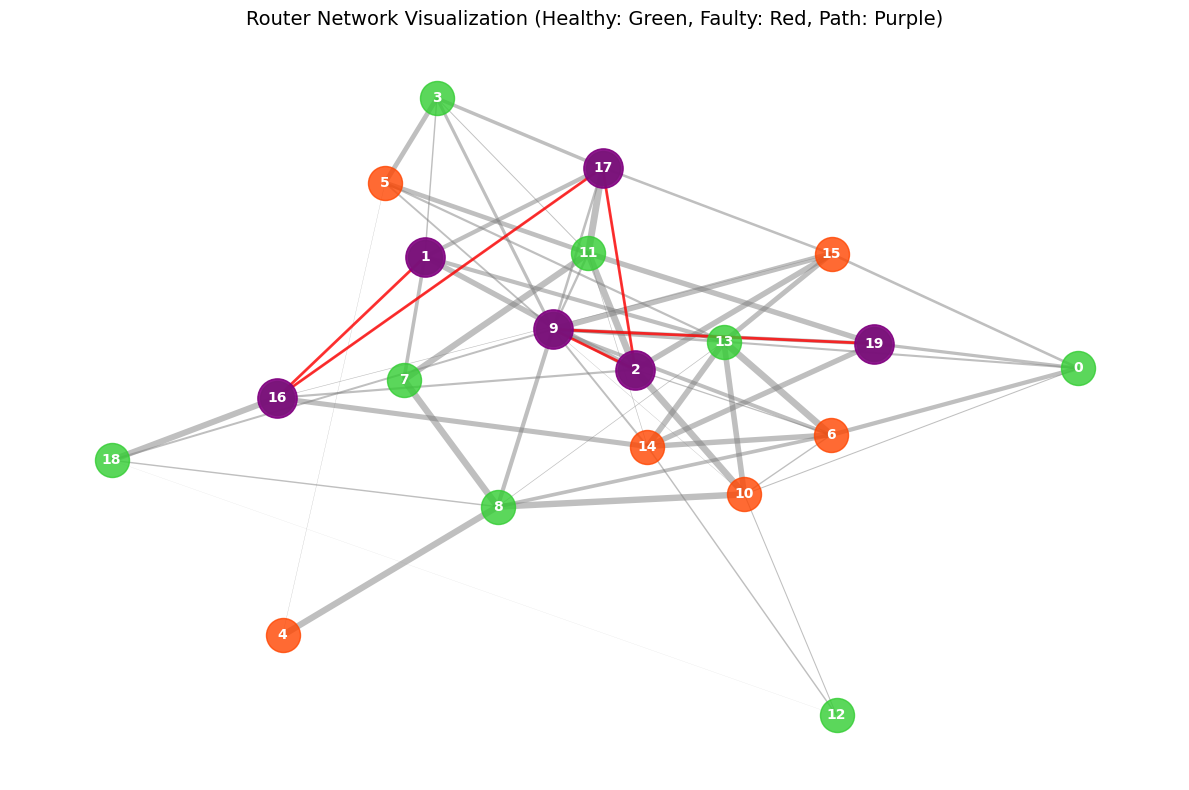

Epoch 0, Loss: 4.440817356109619, Accuracy: 0.0%
Epoch 100, Loss: 1.7370313798892312e-05, Accuracy: 69.9999988079071%
Epoch 200, Loss: 0.0013042911887168884, Accuracy: 69.9999988079071%
Epoch 300, Loss: 5.4384418746167285e-08, Accuracy: 69.9999988079071%
Epoch 400, Loss: 5.268819668752256e-12, Accuracy: 69.9999988079071%
Epoch 500, Loss: 0.00010067341645481065, Accuracy: 75.0%
Epoch 600, Loss: 3.196897413459965e-09, Accuracy: 69.9999988079071%
Epoch 700, Loss: 0.0059771304950118065, Accuracy: 75.0%
Epoch 800, Loss: 9.639709332986968e-07, Accuracy: 69.9999988079071%
Epoch 900, Loss: 1.868143834071745e-11, Accuracy: 69.9999988079071%


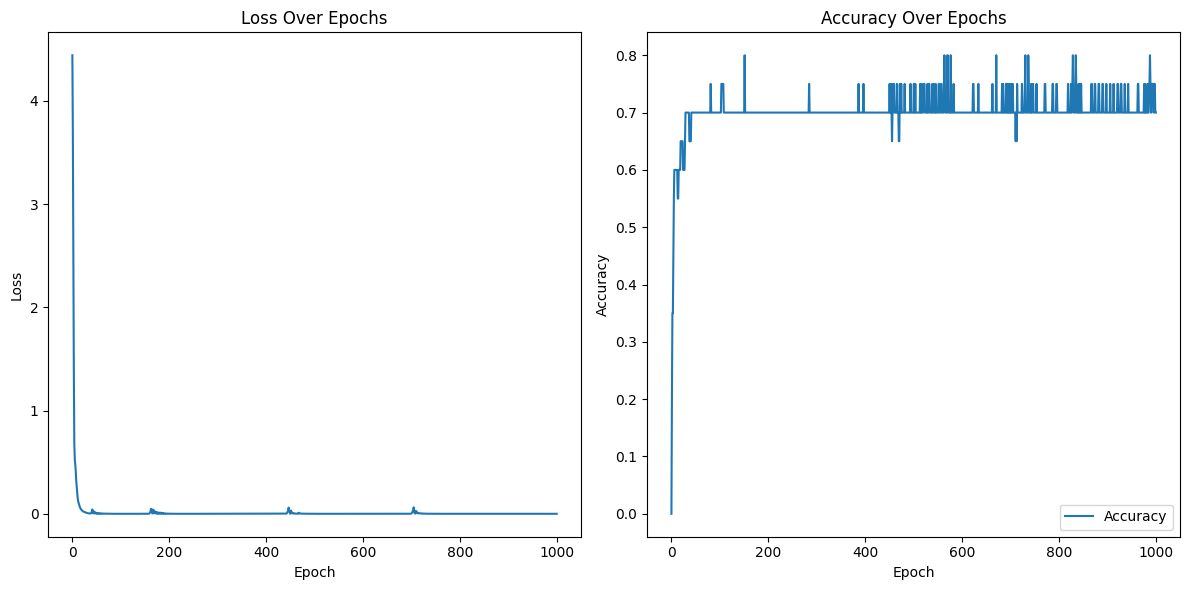

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class RouterNetwork:
    def __init__(self, num_routers=20, fault_probability=0.2):
        """
        Initialize a network of routers with potential faults

        Args:
            num_routers (int): Total number of routers in the network
            fault_probability (float): Probability of a router being faulty
        """
        self.num_routers = num_routers
        self.fault_probability = fault_probability
        self.create_network()

    def create_network(self):
        """
        Create a random network graph with potential faulty routers
        """
        # Create a random graph
        self.graph = nx.erdos_renyi_graph(self.num_routers, 0.3)

        # Randomly mark some routers as faulty
        self.faulty_routers = set(
            router for router in self.graph.nodes
            if np.random.random() < self.fault_probability
        )

        # Assign random weights to edges
        for (u, v) in self.graph.edges():
            self.graph[u][v]['weight'] = np.random.uniform(0.1, 10.0)

    def find_shortest_path(self, source, destination):
        """
        Find the shortest path avoiding faulty routers

        Args:
            source (int): Source router
            destination (int): Destination router

        Returns:
            list: Shortest path avoiding faulty routers
        """
        # Create a copy of the graph without faulty routers
        G = self.graph.copy()

        # Remove faulty routers
        G.remove_nodes_from(self.faulty_routers)

        try:
            # Find shortest path using Dijkstra's algorithm
            shortest_path = nx.shortest_path(G, source=source, target=destination, weight='weight')
            return shortest_path
        except nx.NetworkXNoPath:
            return None

    def visualize_network(self, shortest_path=None):
        """
        Visualize the network with faulty and healthy routers

        Args:
            shortest_path (list, optional): Path to highlight
        """
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42, k=0.15, iterations=20)  # Adjusted layout for better spacing

        # Draw healthy routers in green
        healthy_routers = set(self.graph.nodes) - self.faulty_routers
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=list(healthy_routers),
            node_color='limegreen',
            node_size=600,
            alpha=0.8
        )

        # Draw faulty routers in red
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=list(self.faulty_routers),
            node_color='orangered',
            node_size=600,
            alpha=0.8
        )

        # Draw edges, thickness proportional to edge weight
        edges = self.graph.edges()
        weights = [self.graph[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(
            self.graph,
            pos,
            edgelist=edges,
            width=[w / 2 for w in weights],  # Scale edges by weight
            alpha=0.5,
            edge_color='gray'
        )

        # Highlight shortest path if provided
        if shortest_path:
            path_edges = list(zip(shortest_path, shortest_path[1:]))
            nx.draw_networkx_edges(
                self.graph,
                pos,
                edgelist=path_edges,
                edge_color='red',
                width=2,  # Make the path edges thicker
                alpha=0.8
            )
            nx.draw_networkx_nodes(
                self.graph,
                pos,
                nodelist=shortest_path,
                node_color='purple',
                node_size=800,
                alpha=0.9
            )

        # Draw node labels
        nx.draw_networkx_labels(self.graph, pos, font_size=10, font_weight='bold', font_color='white')

        plt.title("Router Network Visualization (Healthy: Green, Faulty: Red, Path: Purple)", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

class NeuralPathFinder(nn.Module):
    def __init__(self, num_routers):
        """
        Neural network for finding optimal paths

        Args:
            num_routers (int): Total number of routers in the network
        """
        super(NeuralPathFinder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(num_routers * num_routers, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_routers * num_routers)
        )

    def forward(self, adjacency_matrix):
        """
        Forward pass to predict optimal path

        Args:
            adjacency_matrix (torch.Tensor): Network adjacency matrix

        Returns:
            torch.Tensor: Predicted optimal path matrix
        """
        flattened = adjacency_matrix.view(-1)
        return self.network(flattened).view(adjacency_matrix.shape)

def train_path_finder(router_network, epochs=1000):
    """
    Train neural network to find optimal paths around faulty routers

    Args:
        router_network (RouterNetwork): Network configuration
        epochs (int): Number of training epochs

    Returns:
        NeuralPathFinder: Trained neural network
    """
    # Convert graph to adjacency matrix
    adj_matrix = nx.to_numpy_array(router_network.graph)

    # Mark faulty routers in adjacency matrix
    for router in router_network.faulty_routers:
        adj_matrix[router, :] = 0
        adj_matrix[:, router] = 0

    # Convert to PyTorch tensors
    adj_tensor = torch.FloatTensor(adj_matrix)

    # Initialize neural network and optimizer
    model = NeuralPathFinder(router_network.num_routers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        predicted_paths = model(adj_tensor)

        # Loss calculation
        loss = criterion(predicted_paths, adj_tensor)

        # Accuracy calculation: We calculate accuracy based on how many predictions match the adjacency matrix
        correct_predictions = (predicted_paths.argmax(dim=-1) == adj_tensor.argmax(dim=-1)).float()
        accuracy = correct_predictions.mean().item()

        loss.backward()
        optimizer.step()

        # Store loss and accuracy
        loss_history.append(loss.item())
        accuracy_history.append(accuracy)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100}%")

    return model, loss_history, accuracy_history

def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Create router network
    router_network = RouterNetwork(num_routers=20, fault_probability=0.2)

    # Select source and destination routers
    source = 1  # First router
    destination = 19  # Last router

    # Find shortest path avoiding faulty routers
    shortest_path = router_network.find_shortest_path(source, destination)

    if shortest_path:
        print(f"Shortest Path from Router {source} to Router {destination}:")
        print(" -> ".join(map(str, shortest_path)))

        # Visualize network with highlighted path
        router_network.visualize_network(shortest_path)
    else:
        print(f"No path found from Router {source} to Router {destination}")

    # Train neural network path finder
    path_finder, loss_history, accuracy_history = train_path_finder(router_network)

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
